# Semantic Segmentation on Cilia Images using Tiramisu Network in PyTorch


This is a PyTorch implementation of "The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation" (https://arxiv.org/pdf/1611.09326.pdf). This repository is created over the course of two weeks for the project 4 of CSCI 8360 Data Science Practicum at University of Georgia in Spring 2018. 

This repository is benefited from Bendan Fortuner(@bfortuner)'s implementation (https://github.com/bfortuner/pytorch_tiramisu) and ZijunDeng(@ZijunDeng)'s implementation (https://github.com/ZijunDeng/pytorch-semantic-segmentation). 

The goal of this project is to find cilia from a time series of images. Here is a glance of what the data is like:
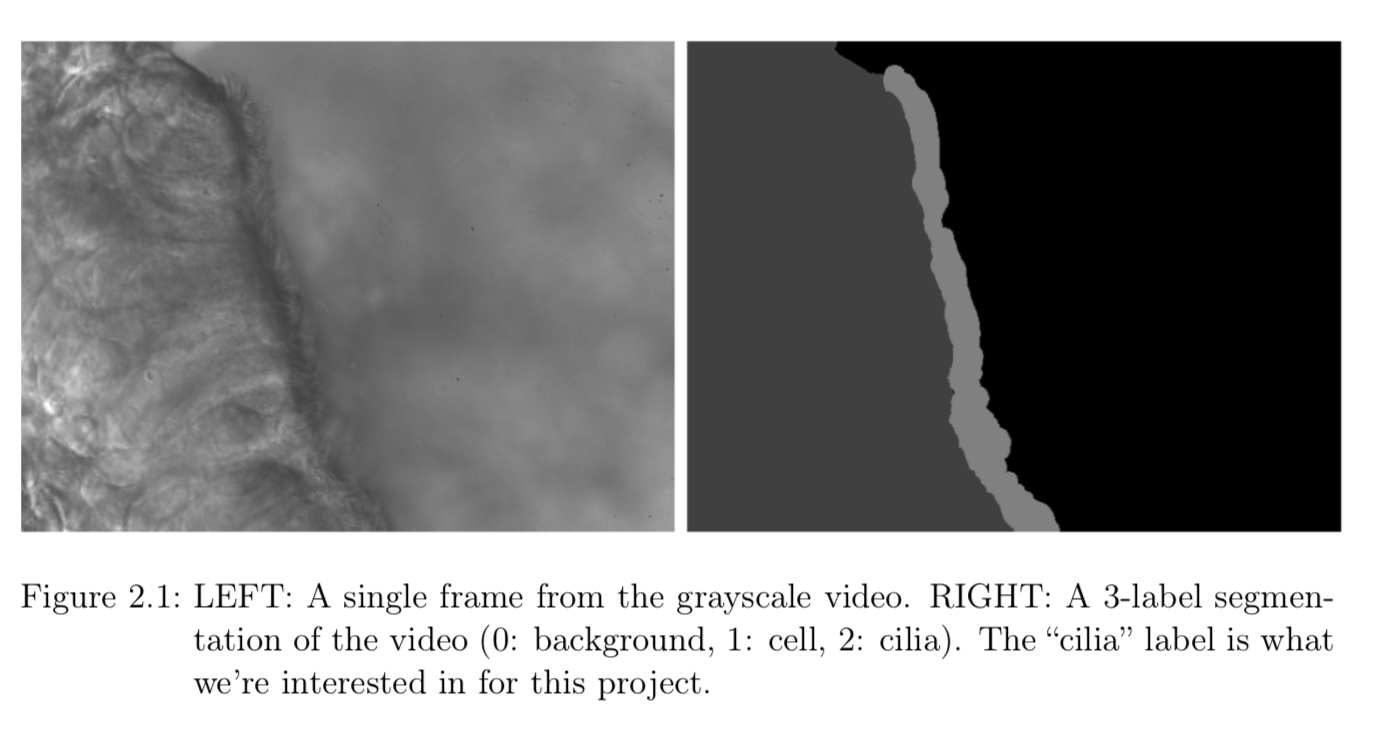 

Cilia motion is an active area of research. Here we are having a small slice of it. There are 100 accompany frames in each cilia motion video. In evaluation, the goal is to only find the cilia (with label 2). The evaluation metric is the area region of intersection-over-union (IoU).

For more background information, check Quinn, Shannon P., et al. "Automated identification of abnormal respiratory ciliary motion in nasal biopsies." Science translational medicine 7.299 (2015): 299ra124-299ra124. (http://stm.sciencemag.org/content/7/299/299ra124).

The reason to use Tiramisu Network (FC-DenseNet) is that there is ample evidence for its effectiveness, and it combines the advanatges of DenseNet and UNet. 

## Loading the required libraries

In [1]:
from datasets import getCilia
from torchvision import transforms
from torch.utils import data
from utils import joint_transforms
from utils import training_utils
import torch.nn as nn
from models import tiramisu
import torchvision
from imageio import imwrite
from imageio import imread
import torch
import matplotlib.pyplot as plt
import time
from pathlib import Path
import os
import numpy as np

## Check PyTorch GPU support

As I will show it later, the code theoretically could also run on a CPU, and we provide APIs for generating masks for the testing set by using the trained model on a CPU. But GPU is much much much better in training. Strongly suggested.

In [2]:
try:
    print ('Your GPU is {}'.format(torch.cuda.get_device_name(0)))
except AttributeError:
    print ('No GPU found!')

No GPU found!


## Load the Training Data

In these following steps, we load the training data. There are in total 211 videos (each with 100 frames) of cilia data. We only take the first frame of it (because although cilia moves in these frames, the range is still not much. We do not take the mean of 100 frames, because the mean would protentially also confuse the network. So we just still to the first one.) 

So we have 211 images and 211 corresponding masks (ground truths). Next, we separate these 211 images and their corresponding masks into training and validiation sets. We have different sizes of the training set in our experiment but in the end the ratio between training and validation datasets is around 9:1. 

In order to load the data into PyTorch, they have to be able to be called from PyTorch's `Dataloader`. Moreover, to augment our dataset, we use RandomSizedCrop and RandomHorizontallyFlip and the training set. (Following the method in C. Lu, M. Marx, C. Chennubhotla, M. Zahid, C. W. Lo, and S. Quinn. "Stacked Neural Networks for Automated Ciliary Motion Analysis." IEEE ISBI. https://arxiv.org/abs/1803.07534) Another benefit of RandomSizedCrop is that it compensates the different demensions of training images, which are (256, 256), (480, 640), etc. due to different techniques in recording. We also provide the option of removing and not removing the cell segments for training (again, it's because the evaluation is only about the cilia.) In this demo, we choose not to remove the cell regions (which is the default setting; to remove them, just change `remove_cell` to `True`.)

In [3]:
# Specify the path for folder
ROOT = '/media/data2TB/jeremyshi/data/cilia/'

# Joint_tranformation for training inputs and targets
train_joint_transformer = joint_transforms.Compose([
    joint_transforms.RandomSizedCrop(256),
    joint_transforms.RandomHorizontallyFlip()
    ])

# Tranformation for training inputs and targets (change them to tensors)
img_transform = transforms.Compose([
    transforms.ToTensor()
    ])

cilia = getCilia.CiliaData(ROOT,
    joint_transform = train_joint_transformer,
    input_transform = img_transform,
    target_transform = img_transform, 
    remove_cell = False)

## Load the training data into PyTorch

In [4]:
train_loader = data.DataLoader(cilia, batch_size = 1, shuffle = True)

### Check the input and target images

Here we take a brief look at the images we have loaded. Notice that the input images are in grey-scale (i.e. only 1 channel).

In [5]:
input_a, target_a = next(iter(train_loader))
print (input_a.size(), target_a.size())

torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])


### Plot on what the image and ground-truth mask are like 


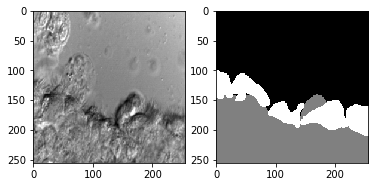

In [6]:
figure, subplot = plt.subplots(1,2)
subplot[0].imshow(input_a[0, 0, :, :], cmap = 'gray')
subplot[1].imshow(target_a[0, :, :], cmap = 'gray')

It Seems that PyTorch dataloader automatically changes the range to (0,1) after calling ToTensor(). So it saves our effort of normalization by dividing the image by 255.

In [7]:
input_a[0, 0, :, :], target_a[0, :, :]

(
  0.8000  0.8039  0.7608  ...   0.8275  0.8392  0.8431
  0.8078  0.7725  0.7608  ...   0.8392  0.8471  0.8510
  0.7608  0.7333  0.7490  ...   0.8471  0.8431  0.8431
           ...             ⋱             ...          
  0.6627  0.6824  0.7216  ...   0.6392  0.6471  0.6471
  0.6863  0.6784  0.6667  ...   0.6431  0.6471  0.6510
  0.6863  0.6275  0.6157  ...   0.6353  0.6627  0.6784
 [torch.FloatTensor of size 256x256], 
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
        ...          ⋱          ...       
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
 [torch.LongTensor of size 256x256])

## Training

Now let's come to the training part. There are the hypoparameters we use.  

In [8]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 3000
torch.cuda.manual_seed(0) # use manual seed for reproductivity

In the `models/tiramisu.py`, there are three different models of Tiramisu implemented -- FCDenseNet57, FCDenseNet67, and FCDenseNet103. For optimal performance, it didn't take us too long to settle on FCDenseNet103. 

For the loss function, we use `NLLLoss` in PyTorch, which is cross-entropy loss, which is the negative log likelihood loss. Alternatively, maybe we can use `CrossEntropyLoss` (need to further test it).

Adam is a good optimizer to use (in our experiments, it works better than SGD, RMSProp, Adagrad).

In [9]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.apply(training_utils.weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss().cuda()

Now we load the valiation set. It uses the same data loader, but we added `validate`. (Default is `train`).

We put the batch_size to 1 here. In validation set, the input images have different sizes, so it's better to do it one by one.

In [10]:
val_cilia = getCilia.CiliaData(ROOT, 'validate',
                  joint_transform = None, 
                  input_transform=img_transform,
                  target_transform=img_transform, 
                  remove_cell = False
                 )

val_loader = torch.utils.data.DataLoader(
                val_cilia, batch_size=1, shuffle=True)

Check (and build) the saved path for storing the results.

In [11]:
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

Now we start training. Notice we save our model *every step*, because the performance may vary a lot (depending on how you set your parameters). We shall choose the one with low validation loss (high validation accuracy). The training result is from a GPU.

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = training_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    training_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 0.9533, Acc: 0.6255
Train Time 0m 15s
Val - Loss: 0.8745 | Acc: 0.6857
Total Time 0m 19s

Epoch 2
Train - Loss: 0.8194, Acc: 0.6723
Train Time 0m 16s
Val - Loss: 0.9246 | Acc: 0.6752
Total Time 0m 20s

Epoch 3
Train - Loss: 0.8243, Acc: 0.6693
Train Time 0m 16s
Val - Loss: 0.8863 | Acc: 0.6664
Total Time 0m 20s

Epoch 4
Train - Loss: 0.7654, Acc: 0.7023
Train Time 0m 16s
Val - Loss: 0.8764 | Acc: 0.6911
Total Time 0m 20s

Epoch 5
Train - Loss: 0.7528, Acc: 0.7085
Train Time 0m 15s
Val - Loss: 0.7267 | Acc: 0.7143
Total Time 0m 20s

Epoch 6
Train - Loss: 0.7335, Acc: 0.7181
Train Time 0m 15s
Val - Loss: 0.7611 | Acc: 0.7187
Total Time 0m 20s

Epoch 7
Train - Loss: 0.7383, Acc: 0.7141
Train Time 0m 16s
Val - Loss: 0.8544 | Acc: 0.7284
Total Time 0m 20s

Epoch 8
Train - Loss: 0.7280, Acc: 0.7178
Train Time 0m 15s
Val - Loss: 0.7448 | Acc: 0.7026
Total Time 0m 20s

Epoch 9
Train - Loss: 0.7017, Acc: 0.7295
Train Time 0m 15s
Val - Loss: 0.8167 | Acc: 0.7132
Total Time 

Epoch 74
Train - Loss: 0.4661, Acc: 0.8216
Train Time 0m 15s
Val - Loss: 0.8766 | Acc: 0.7430
Total Time 0m 19s

Epoch 75
Train - Loss: 0.4776, Acc: 0.8142
Train Time 0m 15s
Val - Loss: 0.6680 | Acc: 0.7647
Total Time 0m 19s

Epoch 76
Train - Loss: 0.4617, Acc: 0.8200
Train Time 0m 15s
Val - Loss: 0.8968 | Acc: 0.7561
Total Time 0m 19s

Epoch 77
Train - Loss: 0.4684, Acc: 0.8206
Train Time 0m 15s
Val - Loss: 1.0482 | Acc: 0.6932
Total Time 0m 19s

Epoch 78
Train - Loss: 0.4480, Acc: 0.8256
Train Time 0m 16s
Val - Loss: 0.8860 | Acc: 0.6869
Total Time 0m 20s

Epoch 79
Train - Loss: 0.4538, Acc: 0.8254
Train Time 0m 15s
Val - Loss: 1.0132 | Acc: 0.7211
Total Time 0m 19s

Epoch 80
Train - Loss: 0.4678, Acc: 0.8175
Train Time 0m 15s
Val - Loss: 1.0192 | Acc: 0.7338
Total Time 0m 20s

Epoch 81
Train - Loss: 0.4402, Acc: 0.8309
Train Time 0m 15s
Val - Loss: 1.1075 | Acc: 0.6312
Total Time 0m 19s

Epoch 82
Train - Loss: 0.4584, Acc: 0.8203
Train Time 0m 15s
Val - Loss: 0.8128 | Acc: 0.7332
To

## Getting Results

In this part of the notebook, we show how to get results from a saved model.

### Loading a model from a GPU

Notice that we have `cuda()` added.

In [ ]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.load_state_dict(torch.load('/media/data2TB/jeremyshi/data/historicalweights/weights-2985-0.473-0.078.pth')['state_dict'])

### Loading the testing set

Again, since the input images have different sizes, so we need to do it one by one. (i.e. set `batch_size` to 1).

In [12]:
test_cilia = getCilia.CiliaData(ROOT, 'test',
                joint_transform = None, 
                input_transform = img_transform
                )


test_loader = torch.utils.data.DataLoader(
                test_cilia, 
                batch_size=1, 
                shuffle=False
                )
    

### Writing results

In [20]:
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results(model, pic)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    

### Now, how to load a model and generate results from a CPU?

We provide similar methods here. In my experience, generating masks for the testing set (114 images) on my MacBook Pro (Early 2015 version, 8G RAM, 2.7G Hz CPU) takes around 75 minutes, and takes a 1080 Ti GPU with 64G RAM machine less than a minute. 

In [15]:
# To load a model from CPU

model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1)
model.load_state_dict(torch.load('/Users/yuanmingshi/Downloads/weights-468-0.567-0.073.pth',  map_location='cpu')['state_dict'])

# Write test results
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results_cpu(model, pic)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    print (str(i) + 'th image done!')

0th image done!
1th image done!
2th image done!
3th image done!
4th image done!
5th image done!
6th image done!
7th image done!
8th image done!
9th image done!
10th image done!
11th image done!
12th image done!
13th image done!
14th image done!
15th image done!
16th image done!
17th image done!
18th image done!
19th image done!
20th image done!
21th image done!
22th image done!
23th image done!
24th image done!
25th image done!
26th image done!
27th image done!
28th image done!
29th image done!
30th image done!
31th image done!
32th image done!
33th image done!
34th image done!
35th image done!
36th image done!
37th image done!
38th image done!
39th image done!
40th image done!
41th image done!
42th image done!
43th image done!
44th image done!
45th image done!
46th image done!
47th image done!
48th image done!
49th image done!
50th image done!
51th image done!
52th image done!
53th image done!
54th image done!
55th image done!
56th image done!
57th image done!
58th image done!
59th im

### Let's see how the results are like!

Here we plot the first image in the testing set and its generated mask (final version).

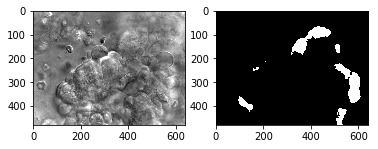

In [17]:
test_a = next(iter(test_loader))
test_res_a = imread('.results/' + test_dir[0] + '.png')
figure, subplot = plt.subplots(1,2)
subplot[0].imshow(test_a[0, 0, :, :], cmap='gray', aspect = 'equal')
subplot[1].imshow(test_res_a, cmap='gray', aspect = 'equal')